In [1]:
# !git clone https://github.com/sovit-123/vision_transformers.git
# %cd vision_transformers

In [2]:
# !pip install .

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import numpy as np
import shutil

from tqdm import tqdm
from vision_transformers.models import swin_transformer

matplotlib.style.use('ggplot')

In [2]:
# Directories.
PROJECT = 'cifar10_swin_t_p4_w7_224'
RES_DIR = os.path.join('results', PROJECT)
if os.path.exists(RES_DIR):
    shutil.rmtree(RES_DIR)
os.makedirs(RES_DIR, exist_ok=True)
PLOT_DIR = os.path.join('plots', PROJECT)
os.makedirs(PLOT_DIR, exist_ok=True)
CKPT_DIR = os.path.join('checkpoints', PROJECT)
os.makedirs(CKPT_DIR, exist_ok=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")
epochs = 5
batch_size = 64

[INFO]: Computation device: cuda


In [4]:
RESIZE_TO = (224, 224)

train_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.RandAugment(num_ops=2),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
     ])
valid_transform = transforms.Compose(
    [transforms.Resize(RESIZE_TO),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
     ])

In [5]:
# training dataset and data loader
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True,
                                             download=True, 
                                             transform=train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               shuffle=True)
# validation dataset and dataloader
valid_dataset = torchvision.datasets.CIFAR10(root='data', train=False,
                                           download=True, 
                                           transform=valid_transform)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                             batch_size=batch_size,
                                             shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# instantiate the model
model = swin_transformer.swin_t_p4_w7_224(image_size=224, num_classes=10, pretrained=True).to(device)
print(model)

/home/sovitdl/miniconda3/envs/experiments/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Initializing new head
SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          dim=96, input_resolution=(56, 56), num_heads=3, window_size=7, shift_size=0, mlp_ratio=4.0
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            dim=96, window_size=(7, 7), num_heads=3
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
    

In [8]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function
criterion = nn.CrossEntropyLoss()
# the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, 
                      weight_decay=0.0005)

[INFO]: 27,527,044 total parameters.
[INFO]: 27,527,044 trainable parameters.


In [9]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1

        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


In [10]:
# validation
def validate(model, testloader, criterion, classes):
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
                        
            if counter == 1:
                gt_color = (0, 255, 0)
                for i in range(image.shape[0]):
                    gt_class = classes[labels[i].cpu().numpy()]
                    pred_class = classes[preds[i].cpu().numpy()]
                    if gt_class == pred_class:
                        pred_color = gt_color
                    else:
                        pred_color = (0, 0, 255)
                    img_to_write = image[i].cpu()
                    img_to_write = img_to_write / 2 + 0.5
                    img_to_write = img_to_write.numpy()
                    img_to_write = np.transpose(img_to_write, (1, 2, 0))
                    img_to_write = cv2.resize(img_to_write, (224, 224))
                    img_to_write = cv2.cvtColor(img_to_write, cv2.COLOR_RGB2BGR)
                    cv2.putText(
                        img_to_write,
                        text=f"GT: {gt_class}",
                        org=(15, 25),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=gt_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.putText(
                        img_to_write,
                        text=f"PRED: {pred_class}",
                        org=(15, 60),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.75,
                        color=pred_color,
                        thickness=2,
                        lineType=cv2.LINE_AA
                    )
                    cv2.imwrite(
                        os.path.join(RES_DIR, 'image_batch'+str(counter)+'image'+str(i)+'.jpg'), 
                        img_to_write*255.
                    )

            # calculate the accuracy for each class
            correct  = (preds == labels).squeeze()
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))

    # print the accuracy for each class after evey epoch
    # the values should increase as the training goes on
    print('\n')
    for i in range(10):
        print(f"Accuracy of {classes[i]}: {100*class_correct[i]/class_total[i]}")

    return epoch_loss, epoch_acc


In [11]:
# start the training
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")

    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_dataloader,                                       
        optimizer, 
        criterion
    )
    valid_epoch_loss, valid_epoch_acc = validate(
        model, 
        valid_dataloader,  
        criterion,
        train_dataset.classes
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)

    print('\n')
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    print('-'*50)


[INFO]: Epoch 1 of 5
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:25<00:00,  5.38it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.51it/s]




Accuracy of airplane: 59.9
Accuracy of automobile: 20.4
Accuracy of bird: 20.8
Accuracy of cat: 38.3
Accuracy of deer: 19.6
Accuracy of dog: 35.3
Accuracy of frog: 29.0
Accuracy of horse: 11.2
Accuracy of ship: 33.4
Accuracy of truck: 12.5


Training loss: 2.139, training acc: 19.756
Validation loss: 1.924, validation acc: 28.040
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:11<00:00,  5.96it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  8.05it/s]




Accuracy of airplane: 64.4
Accuracy of automobile: 22.5
Accuracy of bird: 39.6
Accuracy of cat: 43.6
Accuracy of deer: 17.4
Accuracy of dog: 7.3
Accuracy of frog: 46.3
Accuracy of horse: 22.8
Accuracy of ship: 52.2
Accuracy of truck: 41.1


Training loss: 1.948, training acc: 27.824
Validation loss: 1.699, validation acc: 35.720
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:12<00:00,  5.88it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.80it/s]




Accuracy of airplane: 65.7
Accuracy of automobile: 41.2
Accuracy of bird: 31.4
Accuracy of cat: 43.2
Accuracy of deer: 24.8
Accuracy of dog: 23.3
Accuracy of frog: 55.1
Accuracy of horse: 67.5
Accuracy of ship: 38.1
Accuracy of truck: 74.7


Training loss: 1.713, training acc: 36.952
Validation loss: 1.443, validation acc: 46.500
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:19<00:00,  5.62it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  8.12it/s]




Accuracy of airplane: 53.9
Accuracy of automobile: 90.0
Accuracy of bird: 34.9
Accuracy of cat: 35.2
Accuracy of deer: 50.9
Accuracy of dog: 46.4
Accuracy of frog: 58.1
Accuracy of horse: 64.7
Accuracy of ship: 63.2
Accuracy of truck: 45.3


Training loss: 1.492, training acc: 46.182
Validation loss: 1.296, validation acc: 54.260
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [02:25<00:00,  5.37it/s]


Validation


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  7.90it/s]



Accuracy of airplane: 58.4
Accuracy of automobile: 67.3
Accuracy of bird: 39.5
Accuracy of cat: 21.4
Accuracy of deer: 31.9
Accuracy of dog: 72.1
Accuracy of frog: 63.8
Accuracy of horse: 62.0
Accuracy of ship: 75.3
Accuracy of truck: 75.2


Training loss: 1.351, training acc: 51.876
Validation loss: 1.224, validation acc: 56.690
--------------------------------------------------


In [12]:
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            },  os.path.join(CKPT_DIR, 'mnist_model.pth'))

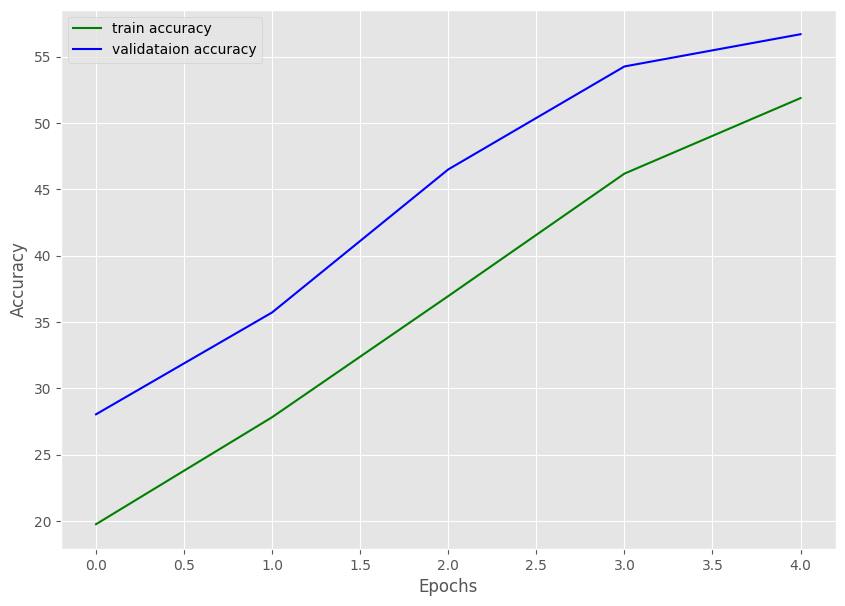

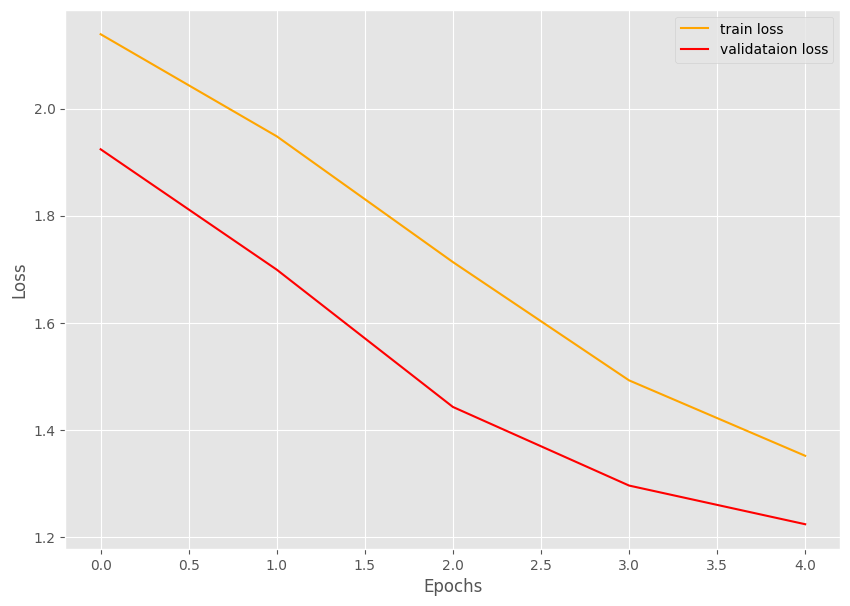

TRAINING COMPLETE


In [13]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'accuracy.png'))
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(PLOT_DIR, 'loss.png'))
plt.show()
 
print('TRAINING COMPLETE')